<a href="https://colab.research.google.com/github/NateshReddy/PCB-Failure-Analyser-playground/blob/main/pcb_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Project/failure_analysis/notebooks")

In [ ]:
import shutil
import cv2
import numpy as np
import json
import glob
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.utils import resample
from fastai.vision import *
import torch, torchvision
from fastai.metrics import error_rate # 1 - accuracy
from fastai.callbacks import EarlyStoppingCallback,SaveModelCallback
print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu101
0.9.1+cu101


# Loading Dataset

In [ ]:
# here valid is given the folder to be used as validation set, test folder refers to images we used as testing images
np.random.seed(42)
path = "training_csvs/"
data = ImageDataBunch.from_folder(path, train='train', valid='test', ds_tfms=get_transforms(), size=224, num_workers=4, bs=10).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data.classes

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
data

ImageDataBunch;

Train: LabelList (1923 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
short,short,short,short,short
Path: training_csvs;

Valid: LabelList (317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
short,short,short,short,short
Path: training_csvs;

Test: None

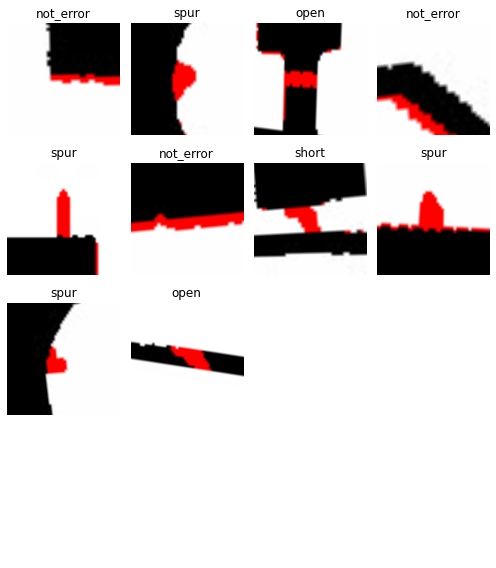

In [ ]:
data.show_batch(rows=4, figsize=(7, 8))

# Train RESNET34

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.586285,0.969268,0.624606,01:37
1,1.009123,0.870405,0.706625,00:19
2,0.755737,0.679346,0.772871,00:19
3,0.763707,0.786651,0.757098,00:19
4,0.646281,0.497401,0.823344,00:19
5,0.531305,0.451458,0.842271,00:19
6,0.487528,0.388132,0.845426,00:19
7,0.375796,0.366000,0.889590,00:19
8,0.339524,0.200218,0.927445,00:20
9,0.342289,0.233396,0.914827,00:19


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


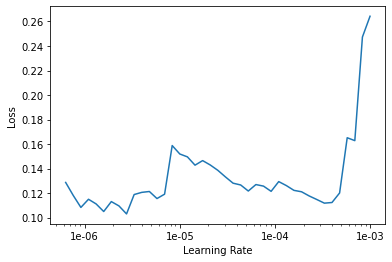

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, max_lr=slice(1e-4, 1e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,accuracy,time
0,0.131741,0.035464,0.984227,00:21
1,0.107637,0.037584,0.990536,00:21
2,0.123763,0.210778,0.927445,00:21
3,0.168469,0.075179,0.971609,00:21
4,0.301134,0.970467,0.829653,00:21
5,0.260501,0.079526,0.974763,00:21
6,0.197088,0.137916,0.943218,00:21
7,0.214323,0.122453,0.952681,00:21
8,0.177273,0.036485,0.987382,00:21
9,0.165791,0.157190,0.930599,00:21


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.03546426072716713.
Better model found at epoch 12 with valid_loss value: 0.017196258530020714.
Better model found at epoch 14 with valid_loss value: 0.016697514802217484.
Better model found at epoch 15 with valid_loss value: 0.010609983466565609.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


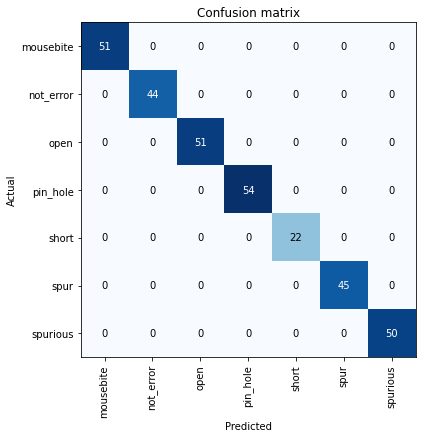

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
learn.export('models/resnet34_2/export.pkl')

# Train VGG16

In [ ]:
learn_vgg = create_cnn(data, models.vgg16_bn, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
defaults.device = torch.device('cuda')
learn_vgg.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.700233,1.002228,0.646688,00:29
1,1.102925,0.835004,0.722397,00:27
2,0.955871,1.011455,0.687697,00:28
3,0.747846,0.589552,0.826498,00:28
4,0.621272,0.873934,0.747634,00:28
5,0.546766,0.471102,0.848580,00:29
6,0.443548,0.417601,0.854890,00:28
7,0.434330,0.620322,0.798107,00:28
8,0.415677,0.295844,0.886435,00:28
9,0.409313,0.210482,0.917981,00:28


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


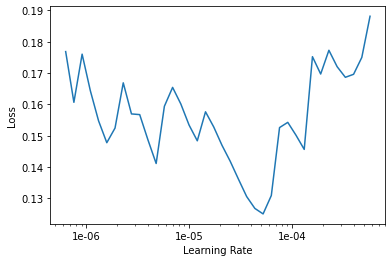

In [ ]:
learn_vgg.unfreeze()
learn_vgg.lr_find()
learn_vgg.recorder.plot()

In [ ]:
learn_vgg.fit_one_cycle(20, max_lr=slice(1e-05, 1e-04), callbacks=[SaveModelCallback(learn_vgg)])

epoch,train_loss,valid_loss,accuracy,time
0,0.146260,0.384178,0.870662,00:36
1,0.117265,0.290654,0.892744,00:37
2,0.140164,0.574326,0.883281,00:38
3,0.134177,0.403008,0.880126,00:38
4,0.176481,0.456189,0.870662,00:38
5,0.175232,0.278303,0.914827,00:38
6,0.135707,0.442293,0.870662,00:38
7,0.142292,0.821560,0.835962,00:38
8,0.118696,0.808806,0.870662,00:38
9,0.091400,0.367559,0.914827,00:38


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.3841783404350281.
Better model found at epoch 1 with valid_loss value: 0.29065388441085815.
Better model found at epoch 5 with valid_loss value: 0.278303325176239.
Better model found at epoch 11 with valid_loss value: 0.25368958711624146.
Better model found at epoch 14 with valid_loss value: 0.21113798022270203.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


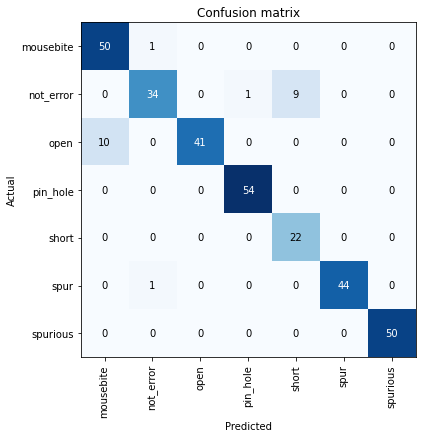

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_vgg)
interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
learn_vgg.export('models/vgg16_2/export.pkl')

# Train inceptionv3

In [ ]:
np.random.seed(42)
path = "training_csvs/"
data_iv3 = ImageDataBunch.from_folder(path, train='train', valid='test', ds_tfms=get_transforms(), size=299, num_workers=4, bs=10).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data_iv3

ImageDataBunch;

Train: LabelList (1923 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
short,short,short,short,short
Path: training_csvs;

Valid: LabelList (317 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
short,short,short,short,short
Path: training_csvs;

Test: None

In [ ]:
import torchvision.models as torch_models # had to import here as it was not readily available with fastai

In [ ]:
def my_loss(preds,target):
  if isinstance(preds, tuple):
    loss = sum((F.cross_entropy(o,target) for o in preds))
  else:
    loss = F.cross_entropy(preds,target)
  return loss

In [ ]:
inceptionModel = torchvision.models.inception_v3(pretrained=True) #loading pretrained model
for param in inceptionModel.parameters(): #freezing layers
  param.requires_grad = False
num_ftrs = inceptionModel.AuxLogits.fc.in_features
inceptionModel.AuxLogits.fc = nn.Linear(num_ftrs, len(data_iv3.classes)) #inserting the linear layer at the end

num_ftrs = inceptionModel.fc.in_features
inceptionModel.fc = nn.Linear(num_ftrs, len(data_iv3.classes))
inceptionModel = inceptionModel.cuda()
learn_iv3 = Learner(data_iv3, inceptionModel, loss_func=my_loss, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
defaults.device = torch.device('cuda')
learn_iv3.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.930599,1.793279,0.195584,00:28
1,2.154891,1.241783,0.577287,00:27
2,1.749249,1.044247,0.618297,00:27
3,1.467716,0.854374,0.659306,00:27
4,1.502418,0.794074,0.690852,00:27
5,1.680565,1.058083,0.643533,00:28
6,1.376062,0.845499,0.694006,00:27
7,1.415335,0.856962,0.697161,00:27
8,1.371035,1.010238,0.646688,00:27
9,1.351945,0.950362,0.678233,00:28


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
learn_iv3.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.029067,0.642188,0.760252,00:27
1,1.254106,0.806700,0.706625,00:28
2,1.236373,1.082232,0.662461,00:28
3,1.390660,0.770480,0.741325,00:28
4,1.518722,0.689713,0.735016,00:28
5,1.257318,0.690400,0.760252,00:28
6,1.183217,0.678204,0.760252,00:28
7,1.126090,0.641953,0.757098,00:28
8,1.160871,0.658639,0.750789,00:28
9,1.053546,0.682334,0.735016,00:28


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


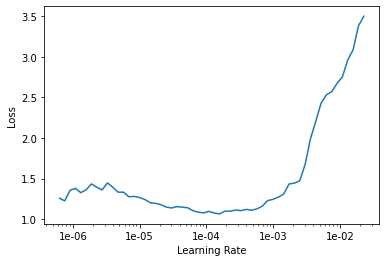

In [ ]:
learn_iv3.unfreeze()
learn_iv3.lr_find()
learn_iv3.recorder.plot()

In [ ]:
learn_iv3.fit_one_cycle(20, max_lr=1e-4, callbacks=[SaveModelCallback(learn_iv3)])

epoch,train_loss,valid_loss,accuracy,time
0,0.947052,0.524697,0.813880,00:38
1,0.645567,0.362658,0.886435,00:39
2,0.490574,0.217347,0.921136,00:39
3,0.637581,0.283602,0.914827,00:39
4,0.451834,0.271135,0.927445,00:38
5,0.546690,0.447701,0.886435,00:38
6,0.533663,0.567141,0.895899,00:38
7,0.290888,0.059143,0.984227,00:38
8,0.264834,0.193246,0.936909,00:39
9,0.378496,0.128241,0.955836,00:38


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.5246973037719727.
Better model found at epoch 1 with valid_loss value: 0.36265814304351807.
Better model found at epoch 2 with valid_loss value: 0.21734729409217834.
Better model found at epoch 7 with valid_loss value: 0.05914280191063881.
Better model found at epoch 14 with valid_loss value: 0.029559941962361336.


In [ ]:
interp = ClassificationInterpretation.from_learner(learn_iv3)
interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
learn_iv3.export('models/inception_2/export.pkl')

# Accuracy Functions

In [ ]:
def recall(y_true,y_pred,label):
    total = 0
    total_r = 0
    for i in range(len(y_true)):
        if y_true[i] == label:
            total+=1
            if y_true[i]==y_pred[i]:
                total_r+=1
    if total == 0:
        return 0
    rec = total_r/total
    return rec
def precision(y_true,y_pred,label):
    total = 0
    total_r = 0
    for i in range(len(y_true)):
        if y_pred[i] == label:
            total+=1
            if y_true[i]==y_pred[i]:
                total_r+=1
    if total == 0:
        return 0
    pres = total_r/total
    return pres

def mean_avg_precision(y_true, y_pred, classes):
  mp = 0
  m = []
  mr = 0
  for cls in classes:
    if cls == 'not_error':
      continue
    else:
      mp = mp + precision(y_true,y_pred,cls)
      mr = mr + recall(y_true,y_pred,cls)
      #m.append(precision(y_true,y_pred,cls))
  fr = mr/(len(classes)-1)
  fp = mp/(len(classes)-1)
  f1 = 2 * (fp * fr) / (fp + fr) # f1 score
  return fp, fr, f1
  

# Validation Accuracy Resnet34

In [ ]:
learn = load_learner('training_csvs/models/resnet34')
learn.data.classes

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
test_dir = "training_csvs/test_50600"
total_count = 0
total_right = 0
y_true = []
y_pred = []
classes = learn.data.classes
for subdir, dirs, files in os.walk(test_dir):
  #print(dirs)
  for d in dirs:
    #print(d)
    for _,_, sfiles in os.walk(os.path.join(test_dir, d)):
      for f in sfiles:
        img_path = os.path.join(test_dir, d, f)
        #print(img_path)
        img = open_image(img_path)
        prediction = learn.predict(img)
        p = learn.data.classes[prediction[1].item()]
        y_true.append(d)
        y_pred.append(p)
        if p == d:
          total_right += 1
        else:
          print(p,d,img_path)
        total_count+=1
print("Accuracy = ", total_right/total_count)
print("Mean Precision, Mean Recall, F1-Score = ", mean_avg_precision(y_true, y_pred, classes))

spur short training_csvs/test_50600/short/extract_1016.png
spur short training_csvs/test_50600/short/extract_1027.png
spur spurious training_csvs/test_50600/spurious/extract_41.png
spur spurious training_csvs/test_50600/spurious/extract_85.png
spur spurious training_csvs/test_50600/spurious/extract_65.png
spur spurious training_csvs/test_50600/spurious/extract_382.png
spur spurious training_csvs/test_50600/spurious/extract_597.png
spur spurious training_csvs/test_50600/spurious/extract_1107.png
spur spurious training_csvs/test_50600/spurious/extract_1067.png
spur spurious training_csvs/test_50600/spurious/extract_1014.png
mousebite open training_csvs/test_50600/open/extract_515.png
mousebite open training_csvs/test_50600/open/extract_1387.png
short not_error training_csvs/test_50600/not_error/extract_163.png
short not_error training_csvs/test_50600/not_error/extract_721.png
short not_error training_csvs/test_50600/not_error/extract_545.png
short not_error training_csvs/test_50600/not_e

# Validation Accuracy VGG16

In [ ]:
learn_vgg = load_learner('training_csvs/models/vgg16')
learn_vgg.data.classes

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
test_dir = "training_csvs/test_50600"
total_count = 0
total_right = 0
y_true = []
y_pred = []
classes = learn.data.classes
for subdir, dirs, files in os.walk(test_dir):
  #print(dirs)
  for d in dirs:
    #print(d)
    for _,_, sfiles in os.walk(os.path.join(test_dir, d)):
      for f in sfiles:
        img_path = os.path.join(test_dir, d, f)
        #print(img_path)
        img = open_image(img_path)
        prediction = learn_vgg.predict(img)
        p = learn_vgg.data.classes[prediction[1].item()]
        y_true.append(d)
        y_pred.append(p)
        if p == d:
          total_right += 1
        else:
          print(p,d,img_path)
        total_count+=1
print("Accuracy = ", total_right/total_count)
print("Mean Precision, Mean Recall, F1-Score = ", mean_avg_precision(y_true, y_pred, classes))

spur spurious training_csvs/test_50600/spurious/extract_41.png
spur spurious training_csvs/test_50600/spurious/extract_85.png
spur spurious training_csvs/test_50600/spurious/extract_382.png
spur spurious training_csvs/test_50600/spurious/extract_597.png
spur spurious training_csvs/test_50600/spurious/extract_1107.png
spur spurious training_csvs/test_50600/spurious/extract_1067.png
spur spurious training_csvs/test_50600/spurious/extract_1014.png
mousebite open training_csvs/test_50600/open/extract_49.png
mousebite open training_csvs/test_50600/open/extract_144.png
mousebite open training_csvs/test_50600/open/extract_515.png
mousebite open training_csvs/test_50600/open/extract_1442.png
mousebite open training_csvs/test_50600/open/extract_1292.png
mousebite open training_csvs/test_50600/open/extract_1387.png
mousebite pin_hole training_csvs/test_50600/pin_hole/extract_145.png
Accuracy =  0.9624664879356568
Mean Precision, Mean Recall, F1-Score =  (0.9637698603755417, 0.9468481810587074, 0

# Validation Accuracy Inception

In [ ]:
def my_loss(preds,target):
  if isinstance(preds, tuple):
    loss = sum((F.cross_entropy(o,target) for o in preds))
  else:
    loss = F.cross_entropy(preds,target)
  return loss

In [ ]:
learn_inc = load_learner('training_csvs/models/inception')
learn_inc.data.classes

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
test_dir = "training_csvs/test_50600"
total_count = 0
total_right = 0
y_true = []
y_pred = []
classes = learn.data.classes
for subdir, dirs, files in os.walk(test_dir):
  #print(dirs)
  for d in dirs:
    #print(d)
    for _,_, sfiles in os.walk(os.path.join(test_dir, d)):
      for f in sfiles:
        img_path = os.path.join(test_dir, d, f)
        #print(img_path)
        img = open_image(img_path)
        prediction = learn_inc.predict(img)
        p = learn_inc.data.classes[prediction[1].item()]
        y_true.append(d)
        y_pred.append(p)
        if p == d:
          total_right += 1
        else:
          print(p,d,img_path)
        total_count+=1
print("Accuracy = ", total_right/total_count)
print("Mean Precision, Mean Recall, F1-Score = ", mean_avg_precision(y_true, y_pred, classes))

mousebite open training_csvs/test_50600/open/extract_515.png
mousebite open training_csvs/test_50600/open/extract_556.png
not_error open training_csvs/test_50600/open/extract_1292.png
mousebite open training_csvs/test_50600/open/extract_1387.png
mousebite open training_csvs/test_50600/open/extract_1443.png
short not_error training_csvs/test_50600/not_error/extract_721.png
Accuracy =  0.9839142091152815
Mean Precision, Mean Recall, F1-Score =  (0.9847323110034975, 0.9747474747474748, 0.9797144532267119)


# Test Accuracy Resnet34

In [ ]:
learn = load_learner('training_csvs/models/resnet34_2')
learn.data.classes

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
test_dir = "training_csvs/test_50600"
total_count = 0
total_right = 0
y_true = []
y_pred = []
classes = learn.data.classes
for subdir, dirs, files in os.walk(test_dir):
  #print(dirs)
  for d in dirs:
    #print(d)
    for _,_, sfiles in os.walk(os.path.join(test_dir, d)):
      for f in sfiles:
        img_path = os.path.join(test_dir, d, f)
        #print(img_path)
        img = open_image(img_path)
        prediction = learn.predict(img)
        p = learn.data.classes[prediction[1].item()]
        y_true.append(d)
        y_pred.append(p)
        if p == d:
          total_right += 1
        else:
          print(p,d,img_path)
        total_count+=1
print("Accuracy = ", total_right/total_count)
print("Mean Precision, Mean Recall, F1-Score = ", mean_avg_precision(y_true, y_pred, classes))

spur spurious training_csvs/test_50600/spurious/extract_41.png
spur spurious training_csvs/test_50600/spurious/extract_85.png
spur spurious training_csvs/test_50600/spurious/extract_65.png
spur spurious training_csvs/test_50600/spurious/extract_382.png
spur spurious training_csvs/test_50600/spurious/extract_597.png
spur spurious training_csvs/test_50600/spurious/extract_1107.png
spur spurious training_csvs/test_50600/spurious/extract_1067.png
spur spurious training_csvs/test_50600/spurious/extract_1014.png
mousebite open training_csvs/test_50600/open/extract_1387.png
Accuracy =  0.9758713136729222
Mean Precision, Mean Recall, F1-Score =  (0.9774159663865546, 0.971557682083998, 0.9744780197306602)


# Test Accuracy VGG16

In [ ]:
learn_vgg = load_learner('training_csvs/models/vgg16_2')
learn_vgg.data.classes

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
test_dir = "training_csvs/test_50600"
total_count = 0
total_right = 0
y_true = []
y_pred = []
classes = learn.data.classes
for subdir, dirs, files in os.walk(test_dir):
  #print(dirs)
  for d in dirs:
    #print(d)
    for _,_, sfiles in os.walk(os.path.join(test_dir, d)):
      for f in sfiles:
        img_path = os.path.join(test_dir, d, f)
        #print(img_path)
        img = open_image(img_path)
        prediction = learn_vgg.predict(img)
        p = learn_vgg.data.classes[prediction[1].item()]
        y_true.append(d)
        y_pred.append(p)
        if p == d:
          total_right += 1
        else:
          print(p,d,img_path)
        total_count+=1
print("Accuracy = ", total_right/total_count)
print("Mean Precision, Mean Recall, F1-Score = ", mean_avg_precision(y_true, y_pred, classes))

spur spurious training_csvs/test_50600/spurious/extract_41.png
spur spurious training_csvs/test_50600/spurious/extract_85.png
spur spurious training_csvs/test_50600/spurious/extract_65.png
spur spurious training_csvs/test_50600/spurious/extract_382.png
spur spurious training_csvs/test_50600/spurious/extract_597.png
spur spurious training_csvs/test_50600/spurious/extract_1143.png
spur spurious training_csvs/test_50600/spurious/extract_1107.png
spur spurious training_csvs/test_50600/spurious/extract_1067.png
spur spurious training_csvs/test_50600/spurious/extract_1014.png
mousebite open training_csvs/test_50600/open/extract_49.png
mousebite open training_csvs/test_50600/open/extract_144.png
mousebite open training_csvs/test_50600/open/extract_515.png
mousebite open training_csvs/test_50600/open/extract_471.png
mousebite open training_csvs/test_50600/open/extract_755.png
mousebite open training_csvs/test_50600/open/extract_1228.png
pin_hole open training_csvs/test_50600/open/extract_1292.

# Test Accuracy Inception

In [ ]:
def my_loss(preds,target):
  if isinstance(preds, tuple):
    loss = sum((F.cross_entropy(o,target) for o in preds))
  else:
    loss = F.cross_entropy(preds,target)
  return loss

In [ ]:
learn_inc = load_learner('training_csvs/models/inception_2')
learn_inc.data.classes

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
test_dir = "training_csvs/test_50600"
total_count = 0
total_right = 0
y_true = []
y_pred = []
classes = learn.data.classes
for subdir, dirs, files in os.walk(test_dir):
  #print(dirs)
  for d in dirs:
    #print(d)
    for _,_, sfiles in os.walk(os.path.join(test_dir, d)):
      for f in sfiles:
        img_path = os.path.join(test_dir, d, f)
        #print(img_path)
        img = open_image(img_path)
        prediction = learn_inc.predict(img)
        p = learn_inc.data.classes[prediction[1].item()]
        y_true.append(d)
        y_pred.append(p)
        if p == d:
          total_right += 1
        else:
          print(p,d,img_path)
        total_count+=1
print("Accuracy = ", total_right/total_count)
print("Mean Precision, Mean Recall, F1-Score = ", mean_avg_precision(y_true, y_pred, classes))

short not_error training_csvs/test_50600/not_error/extract_606.png
short not_error training_csvs/test_50600/not_error/extract_295.png
short not_error training_csvs/test_50600/not_error/extract_849.png
Accuracy =  0.9919571045576407
Mean Precision, Mean Recall, F1-Score =  (0.9886363636363636, 1.0, 0.9942857142857142)
